{[Click here to read this notebook in Google Colab](https://colab.research.google.com/drive/1OicDsxF4twe_cUnhF6mq4CIQ26LJzC6i)}

<head><link rel = "stylesheet" href = "https://drive.google.com/uc?id=1zYOH-_Mb9jOjRbQmghdhsmZ2g6xAwakk"></head>

<table class = "header"><tr>
    <th align = "left">EPAT Batch 45 | EFS 1 - 2020\04\05</th>
    <th align = "right">Written by: Gaston Solari Loudet</th>
</tr></table>

### Statistical arbitrage and pairs' trading

> In this assignment, you will learn to interpret the <b><u>ADF Test</u></b> results and create a <b><u>mean reversion strategy on triplets</u></b>.

> The steps followed are:
* Import the libraries and the data.
* Find the hedge ratio.
* Create the spread.
* Perform ADF Test.
* Mean reversion strategy.
* Plot the profits and losses ("PnL").

This code reads the CSV file using the "``read_csv``" function. We'll now download market history dataframes for the "``GLD``", "``GDX``" and "``USO``" instruments.

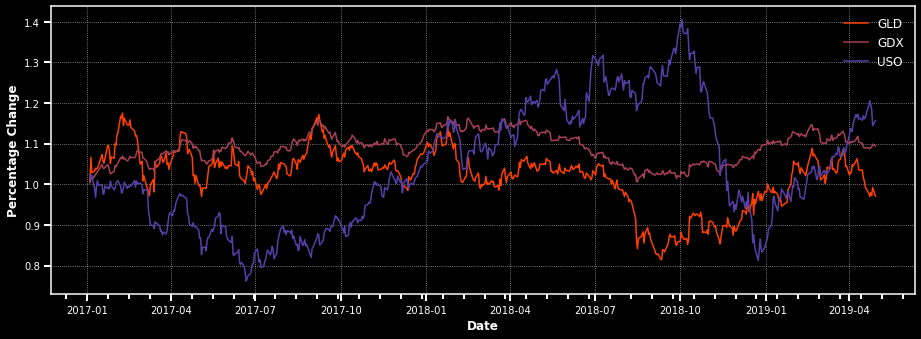

In [5]:
import urllib, numpy, pandas, matplotlib.pyplot, statsmodels.api, IPython
matplotlib.pyplot.style.use("https://drive.google.com/uc?id=1TawPXELPzNlySaOx3HT67A-wHwRxuWjQ")

quotes = {"GLD": "12wlZupG9ogmSFajB_Fn883Bvr4CmsJfh",
          "GDX": "1vOkj0fj-CZlrDKu_3RNslpefnVvBNDIa",
          "USO": "1wy9ExFBgIQhVZiRO-7oTSwot7cvgY5cp"}

Figure_1 = matplotlib.pyplot.figure()
Figure_1.add_axes([0.1, 0.1, 0.8, 0.8])
Data = pandas.DataFrame(columns = quotes.keys())
for n, (quote, ID) in enumerate(quotes.items()):
    URL = "https://drive.google.com/uc?id=" + ID
    df = pandas.read_csv(filepath_or_buffer = URL, index_col = 0)
    Data[quote] = df["Adj Close"].round(2)
    if (n == 0): Data.index = pandas.to_datetime(Data.index)
    Figure_1.axes[0].plot((Data[quote].pct_change() + 1).cumprod(),
        label = quote, color = (1 - n/len(quotes), 1/4, n/len(quotes)))
    
Figure_1.axes[0].set_xlabel(fontsize = 12, fontweight = "bold", xlabel = "Date");
Figure_1.axes[0].set_ylabel(fontsize = 12, fontweight = "bold", ylabel = "Percentage Change");
Figure_1.axes[0].legend(fontsize = 12)
matplotlib.pyplot.pause(1e-13)

#### Hedge ratio

Calculations for Hedge Ratio on each explanatory variable/quote below, based on the initial 90 days ("``hdays``"). Explained variable/quote ("``y``") will be "``GLD``" (1st column of DataFrame, "``[0]``")

In [6]:
hdays = 90  ## Amount of days to be contemplated by the regression.
y = Data.columns[0]   ;   x = list(Data.columns)   ;   x.remove(y)
model = statsmodels.api.OLS(Data[y].iloc[:hdays], Data[x].iloc[:hdays]).fit()
print('Hedge ratios...')
for quote in model.params.index:
    print(" -> %s vs. %s: %.4f" % (quote, y, model.params[quote]))

Hedge ratios...
 -> GDX vs. GLD: 0.1044
 -> USO vs. GLD: 0.9742


#### Cointegration spread

Spread is formed as "$ \Delta S = C_{y} - \Sigma_{x \neq y} \; h_{x} C_{x} $".

* "$h_{x}$" is the hedge ratio for quote "$x$" and "$C_{x}$ is its price.
* "$y$" is a particular quote in which we want to cointegrate the others.
* In this particular case, we use: "$\Delta S = C_{[GLD]} - h_{[GDX]} C_{[GDX]} - h_{[USO]} C_{[USO]}$".
* Series "``model.params[0]``" stores "$h_{[GDX]}$" and "``model.params[1]``" stores "$h_{[USO]}$".

In [7]:
Data['Spread'] = Data[y] - numpy.dot(Data[x], model.params)
Data.head()

,GLD,GDX,USO,Spread
Date,,,,
2017-01-03,21.47,110.47,11.44,-1.209978
2017-01-04,21.63,110.86,11.58,-1.227090
2017-01-05,22.89,112.58,11.70,-0.263593
2017-01-06,22.09,111.75,11.68,-0.957442
2017-01-09,22.16,112.67,11.31,-0.623050


The spread is calculated as  --------->  y[GLD] - 0.1044 x[GDX] - 0.9742 x[USO]


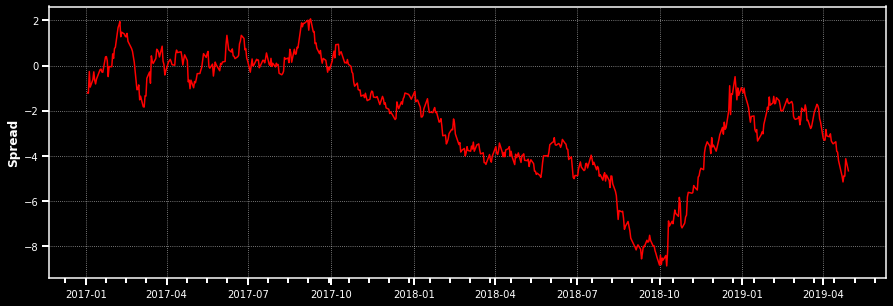

In [8]:
sstr = f"y[{y}] " + " ".join(["- %.4f x[%s]" % (model.params[quote], quote) for quote in model.params.index])
# Plot the spread
print("The spread is calculated as  --------->  %s" % sstr)
Figure_2, _ = matplotlib.pyplot.subplots()
Figure_2.axes[0].plot(Data["Spread"])
Figure_2.axes[0].set_ylabel(ylabel = "Spread", fontsize = 12, fontweight = "bold");

#### ADF Test

We determine the spread is cointegrated using "``adfuller``" method, with "``maxlag = 1``".

In [9]:
# Compute ADF test statistics
adf = statsmodels.tsa.stattools.adfuller(Data["Spread"], maxlag = 1)
print("T-stat for 1st root:", adf[0])
print("Null hypotesis prob:", adf[4])

T-stat for 1st root: -1.2396846239628767
Null hypotesis prob: {'1%': -3.4416553818946145, '5%': -2.8665274458710064, '10%': -2.5694261699959413}


If "T-stat" value is less than the critical value then the spread is cointegrated. Cell below should give "``True``" if the spread is cointegrated and "``False``" if it's not. (Assume 90% confidence level)

In [10]:
is_triplet_cointegrated = (adf[4][list(adf[4].keys())[-1]] <= -1)
print("Is triplet cointegrated? %s" % is_triplet_cointegrated)

Is triplet cointegrated? True


#### Mean reversion

Input parameters:
* "$K$" ("``std_dev``"): Number of standard deviations that define Bollinger bandwidth.
* "$P$" ("``lookback``"): Amount of candles being looked back for their calculation. Also called "period".

Let's call the function "``stat_arb``" with "``df = Data``", "``lookback = 15``" and "``std_dev = 1``".

In [11]:
def stat_arb(df, lookback, std_dev):
    # Calculation of moving average and moving standard dev.
    df['moving_average'] = df["Spread"].rolling(lookback).mean()
    df['moving_std_dev'] = df["Spread"].rolling(lookback).std()
    # Calculation of Bollinger upper and lower bands
    df['upper_band'] = df['moving_average'] + std_dev*df.moving_std_dev
    df['lower_band'] = df['moving_average'] - std_dev*df.moving_std_dev
    # Condition for buying: price below lower band.
    df['long_entry'] = df["Spread"] < df['lower_band']
    # Condition for selling: increasing price reverted to mean.
    df['long_exit'] = df["Spread"] >= df['moving_average']
    # Seek for all long positions, between entry and exit.
    df['positions_long'] = numpy.nan
    df.loc[df['long_entry'], 'positions_long'] = 1
    df.loc[df['long_exit'],  'positions_long'] = 0
    df['positions_long'] = df['positions_long'].fillna(method = 'ffill')
    # Condition for selling: price above upper band.
    df['short_entry'] = df["Spread"] > df['upper_band']
    # Condition for buying: decreasing price reverted to mean.
    df['short_exit'] = df["Spread"] <= df['moving_average']
    # Seek for all short positions, between entry and exit.
    df['positions_short'] = numpy.nan
    df.loc[df['short_entry'], 'positions_short'] = -1
    df.loc[df['short_exit'],  'positions_short'] = 0
    df['positions_short'] = df['positions_short'].fillna(method = 'ffill')
    # Join all position flags.
    df['positions'] = df['positions_long'] + df['positions_short']
    # Get spread increment.
    df['spread_difference'] = df["Spread"] - df["Spread"].shift(1)
    # Get profit and loss.
    df['PNL'] = df['positions'].shift(1) * df['spread_difference']
    df['Cumulative profit'] = df['PNL'].cumsum()
    return df
#################################################### Let's try it.
Data = stat_arb(df = Data, lookback = 15, std_dev = 1)

#### PnL plot

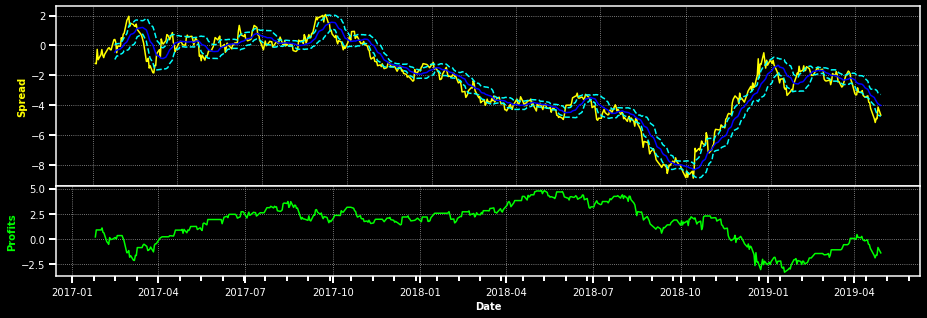

In [12]:
Figure_3 = matplotlib.pyplot.figure()
Figure_3.add_axes([0.10, 0.35, 0.80, 0.50])
Figure_3.add_axes([0.10, 0.10, 0.80, 0.25])
# Axes' names.
Figure_3.axes[0].set_ylabel(fontweight = "bold", color = "yellow", ylabel = "Spread")
Figure_3.axes[1].set_ylabel(fontweight = "bold", color = "lime", ylabel = "Profits")
Figure_3.axes[1].set_xlabel(fontweight = "bold", xlabel = "Date")
# Axes' plots.
Figure_3.axes[0].plot(Data["Spread"], color = 'yellow')
Figure_3.axes[0].plot(Data["upper_band"], linestyle = "--", color = "cyan")
Figure_3.axes[0].plot(Data["lower_band"], linestyle = "--", color = "cyan")
Figure_3.axes[0].plot(Data["moving_average"], color = 'blue')
Figure_3.axes[1].plot(Data["Cumulative profit"], color = 'lime');